# Donors Choose Feature Engineering

The purpose of this notebook is to systematically add features to models and perform analysis to judge their effect on the models.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,f1_score
from sklearn.preprocessing import StandardScaler
import pickle

Load Datasets

In [2]:
projects = pd.read_csv('Data/Projects.csv')
teachers = pd.read_csv('Data/Teachers.csv')
schools = pd.read_csv('Data/Schools.csv')
#donors=pd.read_csv('Data/Donors.csv')
#donations=pd.read_csv('Data/Donations.csv')

Drop all projects that have not been concluded

In [3]:
projects = projects[projects["Project Current Status"] != 'Live']

Drop projects that were duplicates

In [4]:
#projects.loc[projects['Project ID'] == 'c940d0e78b7559573aca536db90c0646']
#projects.loc[projects['Project ID'] == '99c07777fdcf63d3a0fdb4a0deb4b012']
projects=projects.drop([1041063])

projects=projects.drop([983393])

### Part 1: Project Level Features Baseline

Features Added in this section (7): Month of project posted, Project Cost, Teacher Project Number, Project Type, Project Subject, Project Grade Level, Project Supplies Type  

Part 1a: Organize data to use in model
Dummy variables were used to vectorize categorical variables

In [5]:
projects['month'] = pd.DatetimeIndex(projects['Project Posted Date']).month

In [6]:
#project_type_dummies = pd.get_dummies(projects['Project Type'])
main_df = pd.get_dummies(data=projects, columns=['Project Type', 
                                                 'Project Subject Category Tree',
                                                 'Project Grade Level Category',
                                                'Project Resource Category'])

In [7]:
main_df['Funded?']=np.where(projects['Project Current Status']=='Fully Funded', 0, 1)


In [8]:
main_df.drop(['Project Title',
             'Project Essay','Project Short Description','Project Need Statement',
              'Project Subject Subcategory Tree', 'Project Posted Date',
             'Project Expiration Date','Project Current Status','Project Fully Funded Date'],axis='columns',inplace=True)

Part 1b: Fit a simple logistic model to get a baseline model

In [9]:
X_train, X_val, y_train, y_val = train_test_split(main_df.drop(['Funded?','Project ID','School ID','Teacher ID',],axis='columns'),main_df['Funded?'],test_size=0.2,random_state=42)

In [10]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
y_pred = lr_model.predict(X_val)

y_pred_tr = lr_model.predict(X_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
print("Train Logistic Accuracy: "+str(accuracy_score(y_train, y_pred_tr)))
print("Train Logistic Recall: "+str(recall_score(y_train, y_pred_tr)))
print("Train Logistic Precision: "+str(precision_score(y_train, y_pred_tr)))
print("Train Logistic F1: "+str(f1_score(y_train, y_pred_tr)))

print("Test Logistic Accuracy: "+str(accuracy_score(y_val, y_pred)))
print("Test Logistic Recall: "+str(recall_score(y_val, y_pred)))
print("Test Logistic Precision: "+str(precision_score(y_val, y_pred)))
print("Test Logistic F1: "+str(f1_score(y_val, y_pred)))

Train Logistic Accuracy: 0.7761508944672575
Train Logistic Recall: 0.054691672326988586
Train Logistic Precision: 0.5403965367078232
Train Logistic F1: 0.09933045173319772
Test Logistic Accuracy: 0.7745807061643099
Test Logistic Recall: 0.05482189579513381
Test Logistic Precision: 0.5386639676113361
Test Logistic F1: 0.09951569775051888


This is a good starting place to evaluate future models

### Part 2: Add Teacher and School Features

Additional features Added in this section (4): Teacher Prefix, School Metro Area Type, School Percentage Free Lunch, School State

Part 2a: Organize additional data for use in model

In [12]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72993 entries, 0 to 72992
Data columns (total 9 columns):
School ID                       72993 non-null object
School Name                     72993 non-null object
School Metro Type               72993 non-null object
School Percentage Free Lunch    71852 non-null float64
School State                    72993 non-null object
School Zip                      72993 non-null int64
School City                     72766 non-null object
School County                   72991 non-null object
School District                 72993 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 5.0+ MB


In [13]:
projects2 = projects.merge(teachers,how='left',on='Teacher ID')

In [14]:
projects2 = projects2.merge(schools,how='left',on='School ID')

In [15]:
dummies2 = pd.get_dummies(data=projects2, columns=['School Metro Type', 
                                                 'Teacher Prefix',
                                                 'School State'])

In [16]:
dummies2.drop(dummies2.iloc[:, 1:18], axis=1, inplace=True)
dummies2.drop(dummies2.iloc[:, 2:4], axis=1, inplace=True)
dummies2.drop(dummies2.iloc[:, 3:7], axis=1, inplace=True)
#dummies2.info()

In [17]:
main_df = main_df.merge(dummies2,how='left',on='Project ID')

In [18]:
main_df['School Percentage Free Lunch']=main_df['School Percentage Free Lunch'].fillna(main_df['School Percentage Free Lunch'].mean())

Part 2b: Create models to evaluate effect of adding these features

In [19]:
X_train, X_val, y_train, y_val = train_test_split(main_df.drop(['Funded?','Project ID','School ID','Teacher ID',],
                                                               axis='columns'),main_df['Funded?'],
                                                  test_size=0.2,random_state=42)

In [20]:
lr_model2 = LogisticRegression()
lr_model2.fit(X_train,y_train)
y_pred2 = lr_model2.predict(X_val)

y_pred_tr2 = lr_model2.predict(X_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Save model for future use

In [21]:
filename = 'Data/logistic_model_app.sav'
pickle.dump(lr_model2, open(filename, 'wb'))
filename2 = 'Xcols_app'
pickle.dump(X_train.columns, open(filename2, 'wb'))

In [7]:
coef_list = list(zip(lr_model2.coef_[0], X_train.columns))
sorted_coef_list = sorted(coef_list, key=lambda tup: tup[0])
sorted_coef_list

In [75]:
print("Train Logistic Accuracy: "+str(accuracy_score(y_train, y_pred_tr2)))
print("Train Logistic Recall: "+str(recall_score(y_train, y_pred_tr2)))
print("Train Logistic Precision: "+str(precision_score(y_train, y_pred_tr2)))
print("Train Logistic F1: "+str(f1_score(y_train, y_pred_tr2)))

print("Test Logistic Accuracy: "+str(accuracy_score(y_val, y_pred2)))
print("Test Logistic Recall: "+str(recall_score(y_val, y_pred2)))
print("Test Logistic Precision: "+str(precision_score(y_val, y_pred2)))
print("Test Logistic F1: "+str(f1_score(y_val, y_pred2)))

Train Logistic Accuracy: 0.778369655401618
Train Logistic Recall: 0.06972825269751066
Train Logistic Precision: 0.5741365324680869
Train Logistic F1: 0.12435386479013896
Test Logistic Accuracy: 0.7769305303955849
Test Logistic Recall: 0.0693669008426214
Test Logistic Precision: 0.5755555555555556
Test Logistic F1: 0.12381180018018348


### Part 3: Text Features

Additional features Added in this section (6): Project Title, Project Essay, Student Need Description, Project Title Length, Project Essay Length, Student Need Description Length

Part 3a: Create text features and add to features from parts 1 and 2 for use in model

In [76]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068164 entries, 0 to 1110014
Data columns (total 19 columns):
Project ID                          1068164 non-null object
School ID                           1068164 non-null object
Teacher ID                          1068164 non-null object
Teacher Project Posted Sequence     1068164 non-null int64
Project Type                        1068164 non-null object
Project Title                       1068158 non-null object
Project Essay                       1068163 non-null object
Project Short Description           1068161 non-null object
Project Need Statement              1068161 non-null object
Project Subject Category Tree       1068135 non-null object
Project Subject Subcategory Tree    1068135 non-null object
Project Grade Level Category        1068164 non-null object
Project Resource Category           1068128 non-null object
Project Cost                        1068164 non-null float64
Project Posted Date                 1068164 non

In [77]:
text_features = projects[['Project ID','Project Title','Project Essay','Project Need Statement']]

In [78]:
text_features.head()

,Project ID,Project Title,Project Essay,Project Need Statement
0,7685f0265a19d7b52a470ee4bac883ba,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch..."
1,f9f4af7099061fb4bf44642a03e5c331,Learning in Color!,"Help us have a fun, interactive listening cent...","My students need a listening center, read alon..."
2,afd99a01739ad5557b51b1ba0174e832,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...
3,c614a38bb1a5e68e2ae6ad9d94bb2492,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,My students need one copy of each book in The ...
4,ec82a697fab916c0db0cdad746338df9,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...","My students need items such as Velcro, two pou..."


In [79]:
text_features = text_features.fillna('')

In [80]:
text_features['Project Title Length']=text_features['Project Title'].map(str).apply(len)
text_features['Project Essay Length']=text_features['Project Essay'].map(str).apply(len)
text_features['Project Need Staement Length']=text_features['Project Need Statement'].map(str).apply(len)

In [81]:
main_df = main_df.merge(text_features.drop(['Project Title','Project Essay','Project Need Statement'],axis='columns'),how='left',on='Project ID')

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect1 = TfidfVectorizer(max_features=500)
tfidf_vect2 = TfidfVectorizer(max_features=500)
tfidf_vect3 = TfidfVectorizer(max_features=500)

word_freqs_titles = tfidf_vect1.fit_transform(text_features['Project Title'])
word_freqs_essays = tfidf_vect2.fit_transform(text_features['Project Essay'])
word_freqs_needs = tfidf_vect3.fit_transform(text_features['Project Need Statement'])


In [83]:
from scipy.sparse import hstack
use_in_models = hstack((word_freqs_titles,main_df.drop(['Project ID', 'School ID', 'Teacher ID','Funded?'],axis='columns').values))

use_in_models=hstack((use_in_models,word_freqs_essays))

use_in_models=hstack((use_in_models,word_freqs_needs))

In [38]:
with open('Data/word_freqs_needs.pkl', 'wb') as picklefile:
    pickle.dump(word_freqs_needs, picklefile)
with open('Data/word_freqs_essays.pkl', 'wb') as picklefile:
    pickle.dump(word_freqs_essays, picklefile)
with open('Data/word_freqs_titles.pkl', 'wb') as picklefile:
    pickle.dump(word_freqs_titles, picklefile)

Create logistic model to evaluate effect of adding text features

In [84]:
X_train, X_val, y_train, y_val = train_test_split(use_in_models,main_df['Funded?'],
                                                  test_size=0.2,random_state=42)

In [85]:
lr_model3 = LogisticRegression()
lr_model3.fit(X_train,y_train)
y_pred3 = lr_model3.predict(X_val)
y_pred_tr3 = lr_model3.predict(X_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [86]:
print("Train Logistic Accuracy: "+str(accuracy_score(y_train, y_pred_tr3)))
print("Train Logistic Recall: "+str(recall_score(y_train, y_pred_tr3)))
print("Train Logistic Precision: "+str(precision_score(y_train, y_pred_tr3)))
print("Train Logistic F1: "+str(f1_score(y_train, y_pred_tr3)))

print("Test Logistic Accuracy: "+str(accuracy_score(y_val, y_pred3)))
print("Test Logistic Recall: "+str(recall_score(y_val, y_pred3)))
print("Test Logistic Precision: "+str(precision_score(y_val, y_pred3)))
print("Test Logistic F1: "+str(f1_score(y_val, y_pred3)))

Train Logistic Accuracy: 0.779681486101733
Train Logistic Recall: 0.07739690868647693
Train Logistic Precision: 0.5909342834520982
Train Logistic F1: 0.13686773059237217
Test Logistic Accuracy: 0.7782879985769988
Test Logistic Recall: 0.07606254764210223
Test Logistic Precision: 0.5945249597423511
Test Logistic F1: 0.13487004328846192


### Part 4: Addressing Class Imbalance

Because the target classes are relatively imbalanced, I will try to adjust class weights and decision threshold to see if that improves my scores

In [47]:
weights = np.linspace(1,4,10)
scores=[]
for weight in weights:

    lr_model3 = LogisticRegression(class_weight={1:weight,0:1})
    lr_model3.fit(X_train,y_train)
    y_pred3 = lr_model3.predict(X_val)
    y_pred_tr3 = lr_model3.predict(X_train)
    
    scores.append(f1_score(y_val, y_pred3))

best = np.max(scores) 
best_weight = weights[np.argmax(scores)]

print(best,best_weight)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4732338530688591 3.6666666666666665


Logistic Regression Model best F1 score 0.463 at prob decision threshold >= 0.498


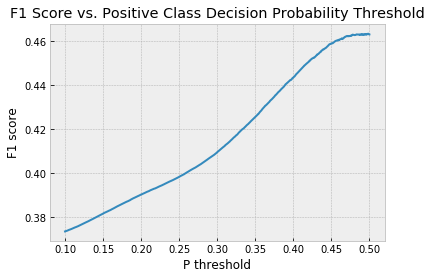

In [159]:
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = lr_model3.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(model_val_labels, y_val))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))